# SUDOKU lösen mit verschiedenen Quanten Computing Ansätzen

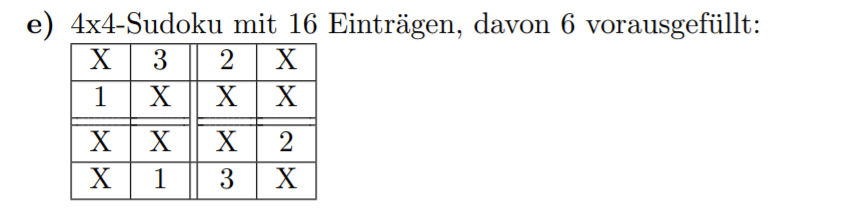

In [1]:
import utils
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

C:\Users\potap\AppData\Local\Programs\Python\Python38\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
C:\Users\potap\AppData\Local\Programs\Python\Python38\lib\site-packages\qiskit\optimization\__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('optimization', 'qiskit_optimization', 'qiskit-optimization')



## Variablen Deklaration:
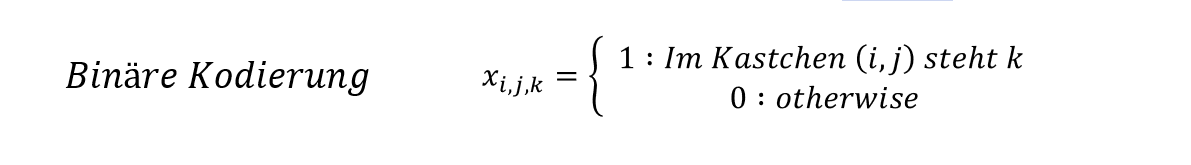

In [79]:
row_num = 4
column_num = 4
k_max = max(row_num, column_num)

num_sub_row = 2
num_sub_column = 2
block_size = 2

In [80]:
#Gewichte für Penalty funktions

alpha = 2
beta = 2
gamma = 2
delta = 1

In [81]:
# known values
known_vars = {}

known_vars[(0,1)] = 2
known_vars[(0,2)] = 1

known_vars[(1,0)] = 0

known_vars[(2,3)] = 1

known_vars[(3,1)] = 0
known_vars[(3,2)] = 2


In [82]:
all_vars = utils.get_all_vars(row_num, column_num, k_max)
var_list = utils.get_unbekannte_vars(row_num, column_num, k_max, known_vars)
prunned_list = utils.get_prunned_vars(row_num, column_num, k_max, num_sub_row, num_sub_column, block_size, known_vars)

In [83]:
prunned_list

[(0, 0, 3),
 (0, 3, 0),
 (0, 3, 3),
 (1, 1, 1),
 (1, 1, 3),
 (1, 2, 3),
 (1, 3, 2),
 (1, 3, 3),
 (2, 0, 2),
 (2, 0, 3),
 (2, 1, 3),
 (2, 2, 0),
 (2, 2, 3),
 (3, 0, 1),
 (3, 0, 3),
 (3, 3, 3)]

In [84]:
p_list = []
appender = []
remember = prunned_list[0]
for tupel in prunned_list:
    if (tupel[0] != remember[0] or tupel[1] != remember[1]):
        remember = tupel
        if (len(appender) > 1):
            for a in appender:
                p_list.append(a)
        else:
            known_vars[(appender[0][0], appender[0][1])] = appender[0][2]
        appender = []
        appender.append(tupel)
    else:
        appender.append(tupel)
        
if (len(appender) > 1):
    for a in appender:
        p_list.append(a)
else:
    known_vars[(appender[0][0], appender[0][1])] = appender[0][2]

In [86]:
p_list

[(0, 3, 0),
 (0, 3, 3),
 (1, 1, 1),
 (1, 1, 3),
 (1, 3, 2),
 (1, 3, 3),
 (2, 0, 2),
 (2, 0, 3),
 (2, 2, 0),
 (2, 2, 3),
 (3, 0, 1),
 (3, 0, 3)]

In [87]:
known_vars

{(0, 1): 2,
 (0, 2): 1,
 (1, 0): 0,
 (2, 3): 1,
 (3, 1): 0,
 (3, 2): 2,
 (0, 0): 3,
 (1, 2): 3,
 (2, 1): 3,
 (3, 3): 3}

In [88]:
len(p_list)

12

In [89]:
len(prunned_list)

16

In [90]:
prunned_list = p_list

-------

# Constraints and Penalty functions

In [91]:
n = len(prunned_list)
QUBO = np.zeros((n,n))

### Constraint 1: A single cell can only have one number

$$
\sum_{k=1}^{9} X_{i j k}=1, \quad \forall i j \in \text {cell}
$$

#### Here, we introduce a penalty weight $\alpha$.

$$
\alpha \sum_{i j}\left(\sum_{k=1}^{9} x_{i j k}-1\right)^{2}
$$

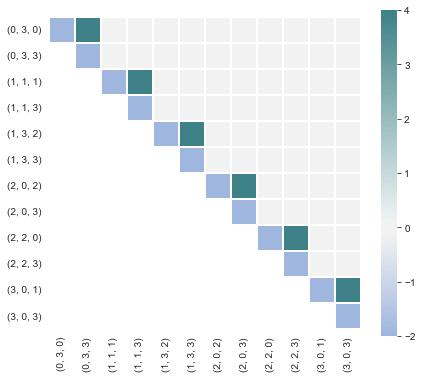

In [92]:
QUBO = utils.h1_penalty(alpha, QUBO, prunned_list)
penalty = 'h1'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### Constraint 2: Each column j can not have a duplicate number

$$
 \sum_{i} X_{i j k}=1, \quad \forall j \in \text { column }, \forall k \in K(K=\{1 . .9\})
$$

#### Here, we introduce a penalty weight $\beta$.

$$
\beta \sum_{k=1}^{9} \sum_{j}\left(\sum_{i} x_{i j k}-1\right)^{2}
$$

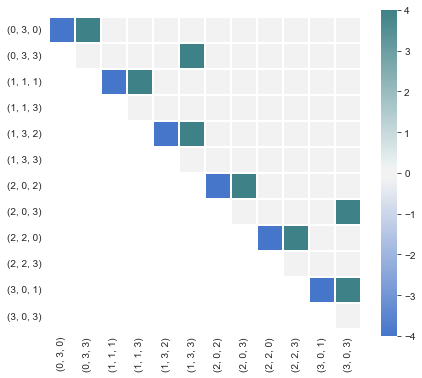

In [93]:
QUBO = utils.h2_penalty(beta, QUBO, prunned_list, all_vars, known_vars)
penalty = 'h2'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### Constraint 3: Each column row i cannot have any duplicate number

$$
 \sum_{j} X_{i j k}=1, \quad \forall i \in \text { row }, \forall k \in K(K=\{1 . .9\})
$$

#### Here, we introduce a penalty weight $\gamma$.

$$
\gamma \sum_{k=1}^{9} \sum_{i}\left(\sum_{j} x_{i j k}-1\right)^{2}
$$

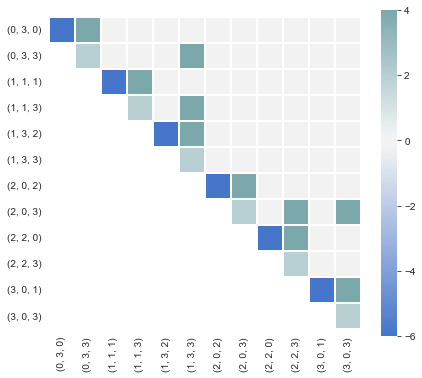

In [94]:
QUBO = utils.h3_penalty(gamma, QUBO, prunned_list, all_vars, known_vars)
penalty = 'h3'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

### Constraint 4: Each of the subgrids cannot have any duplicate number

$$
\sum_{subgrid} x_{ijk}=1, \quad \forall k \in\{1 . .9\} \text{         } 
\forall subgrid 
$$


#### Here, we introduce a penalty weight $\delta$.

$$
\delta \sum_{k=1}^{9}\left(\sum_{subgrid} x_{ijk}-1\right)^{2}
$$

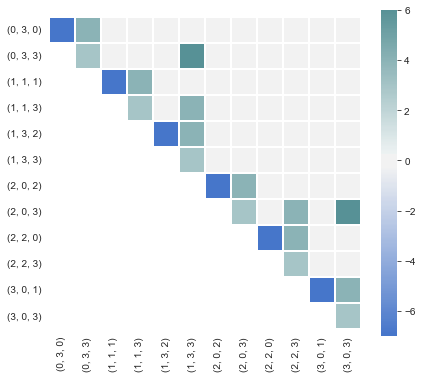

In [95]:
all_blocks = utils.get_all_blocks(num_sub_row, num_sub_column)
QUBO = utils.h4_penalty(delta, QUBO, prunned_list, all_vars, known_vars, block_size, all_blocks)
penalty = 'h4'
utils.get_qubo_heatmap(QUBO, prunned_list, penalty)

--------

In [96]:
known_vars

{(0, 1): 2,
 (0, 2): 1,
 (1, 0): 0,
 (2, 3): 1,
 (3, 1): 0,
 (3, 2): 2,
 (0, 0): 3,
 (1, 2): 3,
 (2, 1): 3,
 (3, 3): 3}

In [97]:
prunned_list

[(0, 3, 0),
 (0, 3, 3),
 (1, 1, 1),
 (1, 1, 3),
 (1, 3, 2),
 (1, 3, 3),
 (2, 0, 2),
 (2, 0, 3),
 (2, 2, 0),
 (2, 2, 3),
 (3, 0, 1),
 (3, 0, 3)]

# Lösung mit QBSolve (Simulated Annealing)

In [98]:
first_sample

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 0}

In [99]:
qubo_d = utils.matrix_to_dictionary(QUBO)
sampleset = utils.on_QBsolve(qubo_d)
first_sample = sampleset.samples()[0]
result = [y for _, y in first_sample.items()]

In [100]:
solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, result)

print(solution)

[[3. 2. 1. 0.]
 [0. 1. 3. 2.]
 [2. 3. 0. 1.]
 [1. 0. 2. 3.]]


-----

# Lösung mit DWave (DWave Advantage)

In [113]:
sampleset = utils.on_DWave(QUBO, 100)
first_sample = sampleset.samples()[0]
result = [y for _, y in first_sample.items()]

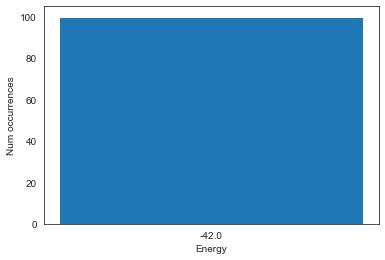

In [114]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt

# Make a random dataset:
energies = sampleset.record.energy
num_occ = sampleset.record.num_occurrences
y_pos = np.arange(len(energies))

# Create bars
plt.bar(y_pos, num_occ)

# Create names on the x-axis
plt.xticks(y_pos, energies)
plt.xlabel('Energy')
plt.ylabel('Num occurrences')
# Show graphic
#plt.show()
plt.savefig('dwave.jpg')

In [110]:
sampleset

SampleSet(rec.array([([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0], -42., 1000, 0.)],
          dtype=[('sample', 'i1', (12,)), ('energy', '<f8'), ('num_occurrences', '<i4'), ('chain_break_fraction', '<f8')]), Variables(range(0, 12)), {'timing': {'qpu_sampling_time': 132620.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 92.08, 'qpu_access_time': 141067.8, 'qpu_access_overhead_time': 10678.2, 'qpu_programming_time': 8447.8, 'qpu_delay_time_per_sample': 20.54, 'total_post_processing_time': 285.0, 'post_processing_overhead_time': 285.0}, 'problem_id': '8890646a-6d4f-458e-8738-cd6c9cad03c6'}, 'BINARY')

In [16]:
solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, result)
print(solution)

[[3. 2. 1. 0.]
 [0. 1. 3. 2.]
 [2. 3. 0. 1.]
 [1. 0. 2. 3.]]


----------

# Lösung mit QAOA (Qiskits QuadraticProgram)

In [101]:
quadr_program = utils.QUBO_to_QuadraticProgram(QUBO)
print(quadr_program)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: [ - 14 x0^2 + 8 x0*x1 + 6 x1^2 + 12 x1*x5 - 14 x2^2 + 8 x2*x3 + 6 x3^2
      + 8 x3*x5 - 14 x4^2 + 8 x4*x5 + 6 x5^2 - 14 x6^2 + 8 x6*x7 + 6 x7^2
      + 8 x7*x9 + 12 x7*x11 - 14 x8^2 + 8 x8*x9 + 6 x9^2 - 14 x10^2 + 8 x10*x11
      + 6 x11^2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1
 0 <= x6 <= 1
 0 <= x7 <= 1
 0 <= x8 <= 1
 0 <= x9 <= 1
 0 <= x10 <= 1
 0 <= x11 <= 1

Binaries
 x0 x1 x2 x3 x4 x5 x6 x7 x8 x9 x10 x11
End



optimal params:       {ParameterVectorElement(θ[0]): -3.8447960383575226, ParameterVectorElement(θ[1]): 6.693985160454964}
optimal value:        -3.524108897441014


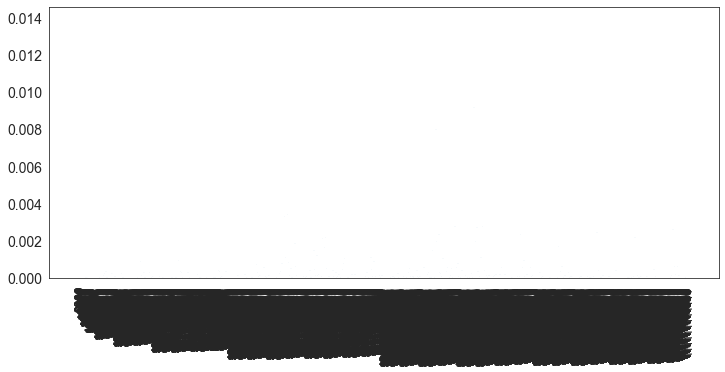

<generator object on_qiskit.<locals>.<genexpr> at 0x0000014B9260D3C0>


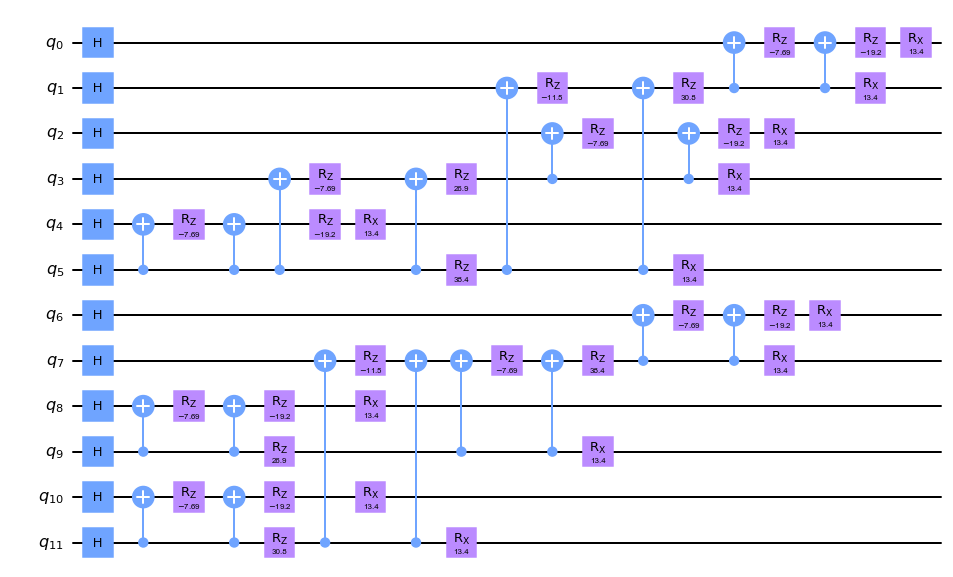

In [115]:
from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')

qc = utils.on_qiskit(quadr_program, backend, with_graphic = True)[1]
display(qc.draw('mpl'))

In [103]:
from qiskit import QuantumCircuit, Aer, assemble, IBMQ, transpile
for kk in range(4):
    trans_qc = transpile(qc, basis_gates=['cx', 'u3'], optimization_level=kk)
    
    #display(trans_qc.draw())
    print('Optimization Level {}'.format(kk))
    print('Depth:', trans_qc.depth())
    print('Gate counts:', trans_qc.count_ops())

Optimization Level 0
Depth: 17
Gate counts: OrderedDict([('u3', 46), ('cx', 20)])
Optimization Level 1
Depth: 16
Gate counts: OrderedDict([('u3', 40), ('cx', 20)])
Optimization Level 2
Depth: 16
Gate counts: OrderedDict([('u3', 40), ('cx', 20)])
Optimization Level 3
Depth: 16
Gate counts: OrderedDict([('u3', 40), ('cx', 20)])


In [105]:
trans_qc.count_ops()['u3'] + 10 * trans_qc.count_ops()['cx']

240

In [106]:
costs = utils.get_costs(qc)

OrderedDict([('u3', 46), ('cx', 20)])
Cost: 246


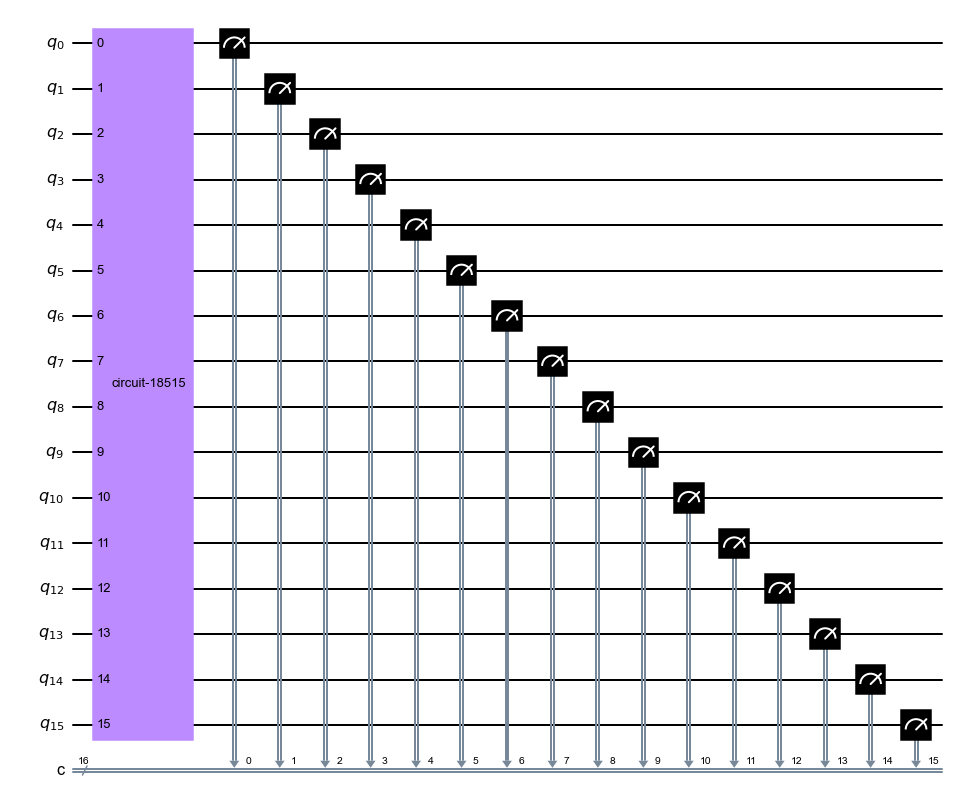

In [27]:
from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')
counts = utils.measure_ciruit(qc, backend, shots = 1000)
result = counts.most_frequent()

In [28]:
solution = utils.visualize_solution(row_num, column_num, prunned_list, known_vars, result)
print(solution)

KeyError: (3, 3)

In [63]:
# Run quantum algorithm QAOA on qasm simulator
#optimizer = SPSA(maxiter=250)
optimizer = COBYLA(maxiter=250)#

backend = Aer.get_backend('qasm_simulator')

qaoa = QAOA(optimizer=optimizer, quantum_instance=backend)
algorithm = MinimumEigenOptimizer(qaoa)
result = algorithm.solve(quadr_program)
print(result)

optimal function value: -44.0
optimal value: [0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1.]
status: SUCCESS


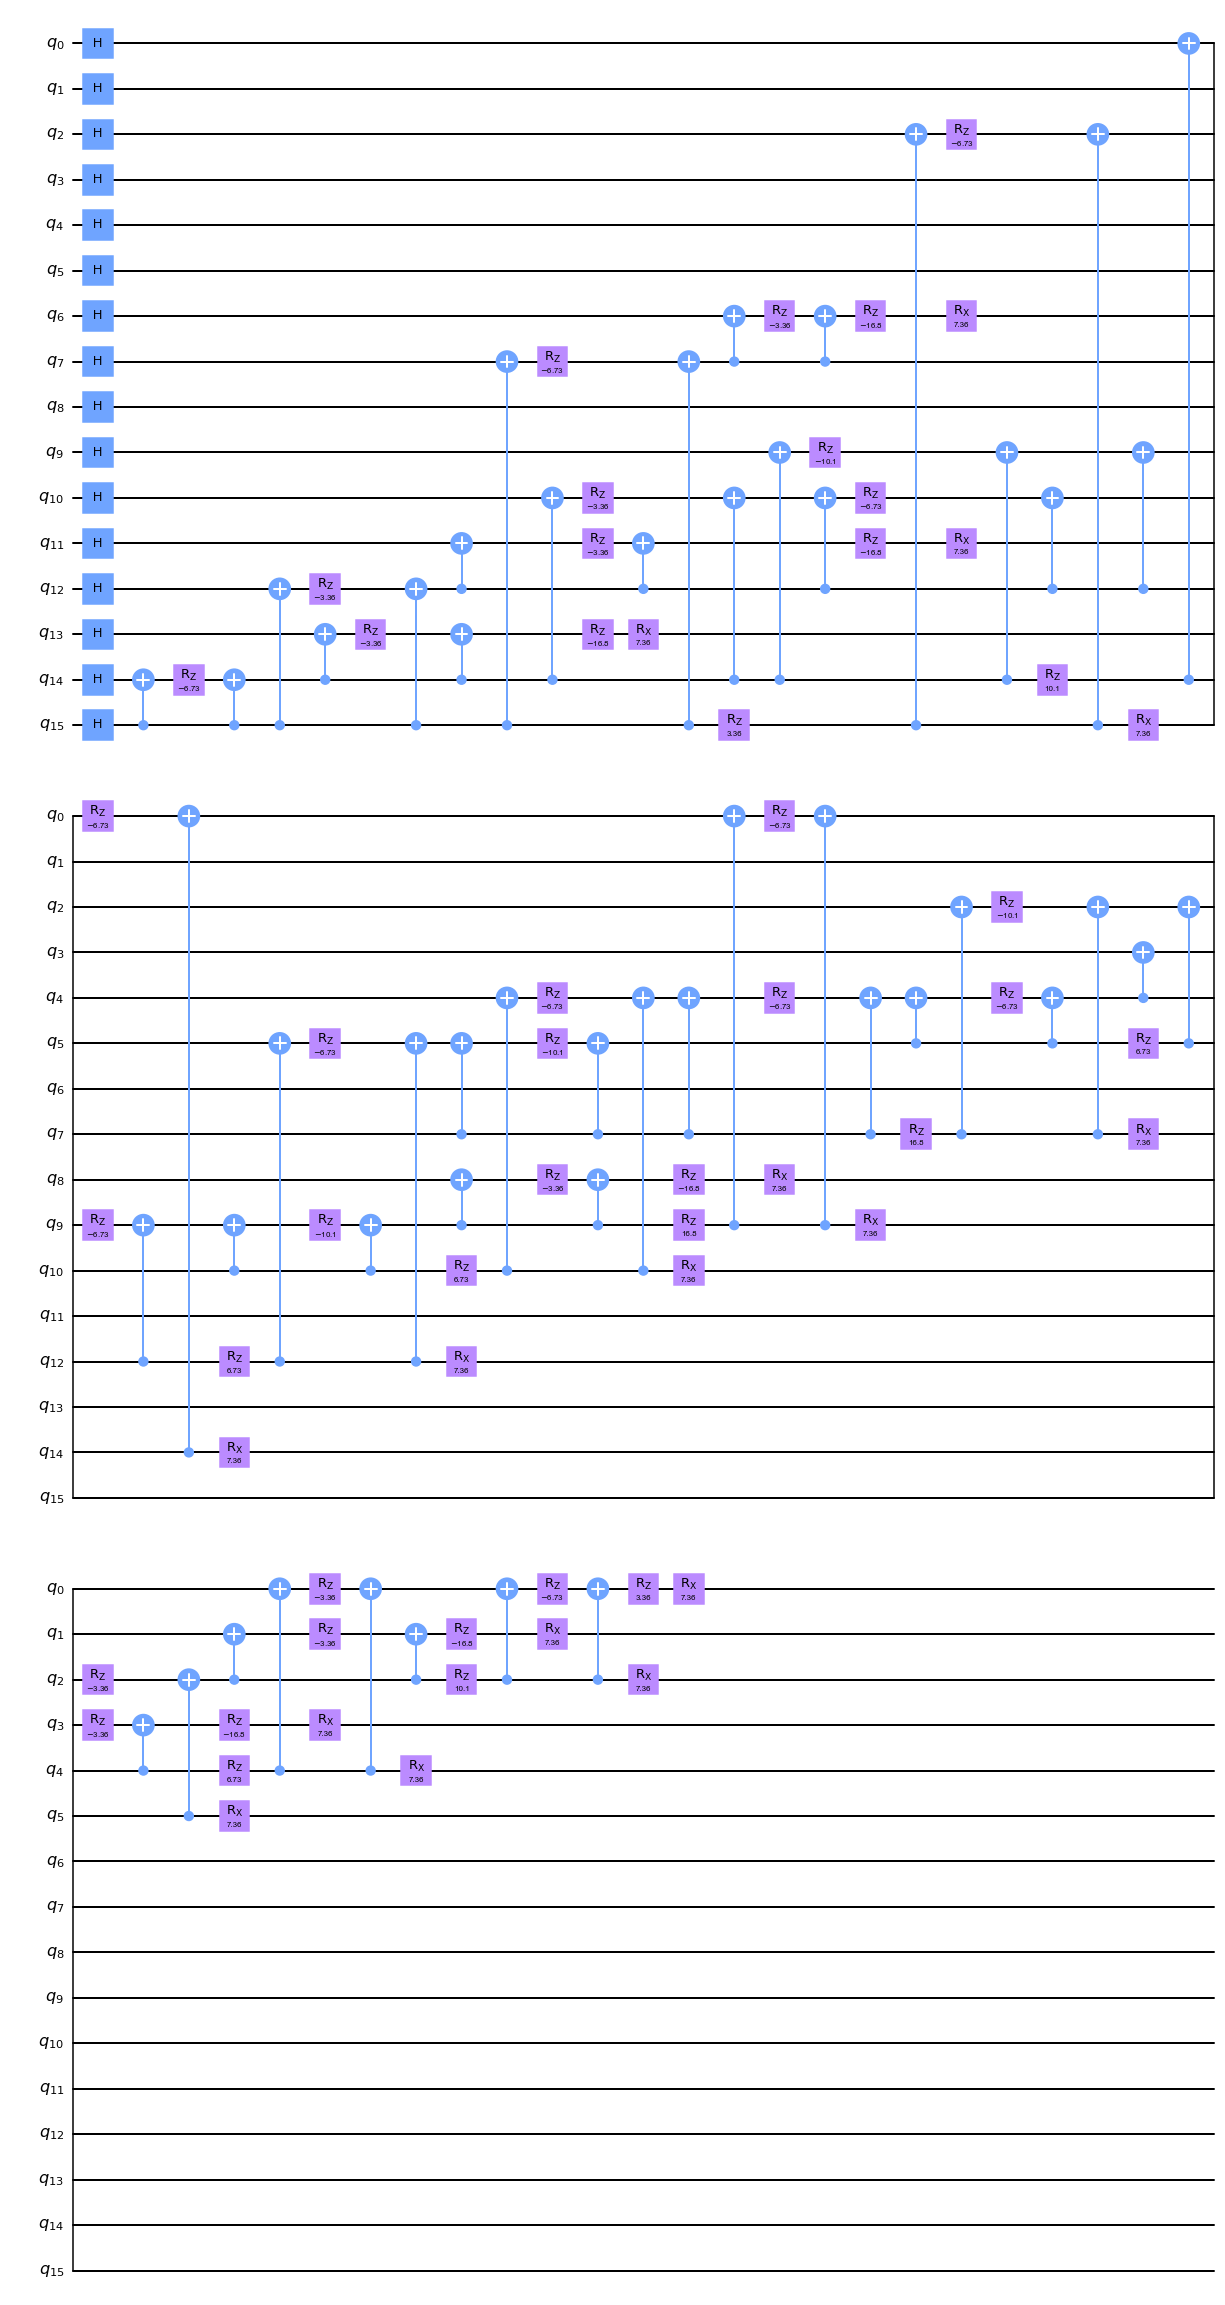

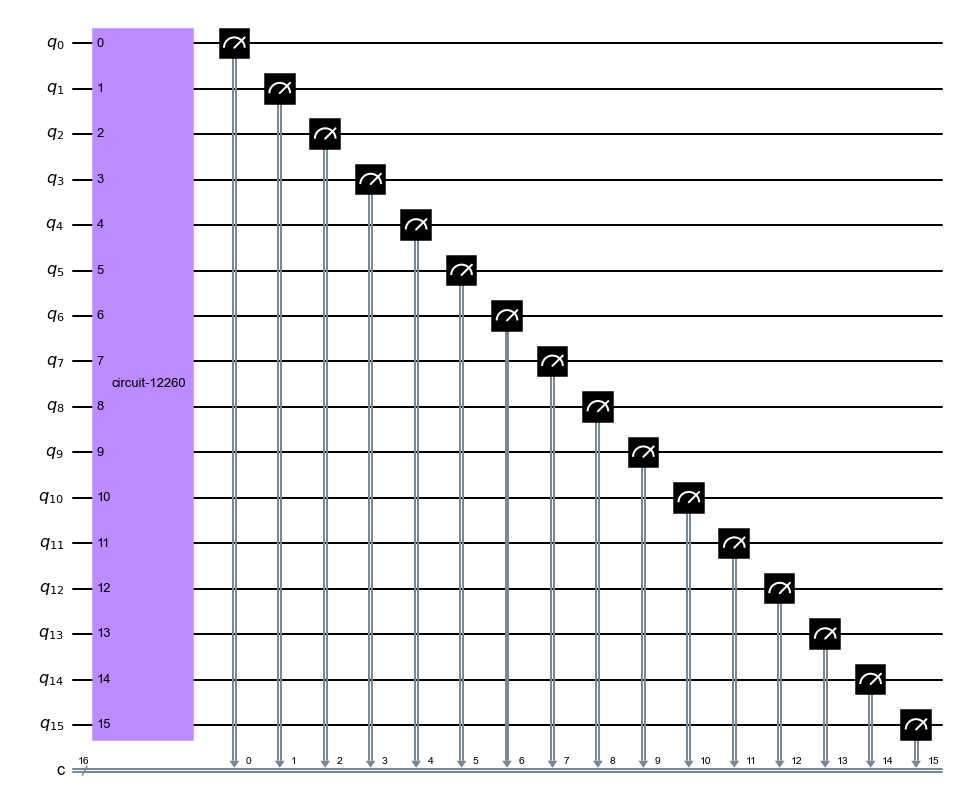

In [64]:
qc = qaoa.get_optimal_circuit()
display(qc.draw('mpl'))
gate = qc.to_gate() 

wires = range(n)

qc_qaoa = QuantumCircuit(n, n)
qc_qaoa.append(gate, wires)
qc_qaoa.measure(wires, wires)
display(qc_qaoa.draw('mpl'))

### Kosten:

In [65]:
pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_)
new_circuit = pm.run(qc)

ops = new_circuit.count_ops()
print(ops)
cost = ops['u3'] + 10 * ops['cx'] 
print("Cost: " + str(cost))
#new_circuit.draw(output='mpl')

OrderedDict([('u3', 74), ('cx', 52)])
Cost: 594


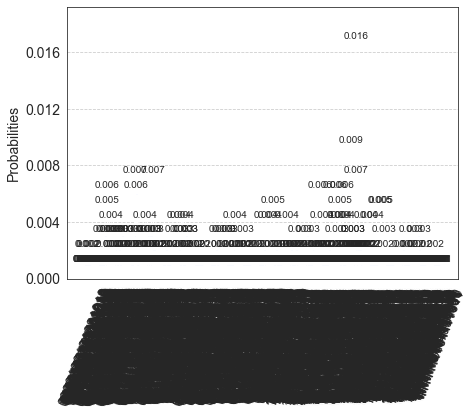

In [75]:
shots = 1000
job = execute(qc_qaoa, backend, shots = shots)
plot_histogram(job.result().get_counts(qc_qaoa))

In [76]:
result = job.result().get_counts(qc_qaoa).most_frequent()

In [77]:
solution = visualize_solution(row_num, column_num, prunned_list, known_vars, result)
print(solution)

[[4. 3. 2. 4.]
 [1. 4. 4. 4.]
 [4. 4. 4. 2.]
 [4. 1. 3. 4.]]
